### Removed

* [x] 2020-11-26 shot 1
* [X] 2020-11-26 shot 5
* [x] 2020-11-26 shot 6
* [x] 2020-12-09 shot 6
* [x] 2020-12-21 shot 9
* [x] 2020-12-27 shot 8

### Update
* [x] 2020-11-23 shot 5
* [x] 2020-11-24 shot 2
* [x] 2020-11-25 shot 3
* [x] 2020-12-08 shot 6
* [x] 2020-12-09 shot 0

In [1]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import uncertainties as un
from matplotlib import pyplot as plt
from scipy.stats import t
from uncertainties import unumpy as unp

from funcs.dir import d_drive
from funcs.post_processing.images.soot_foil.deltas import get_px_deltas_from_lines, Shot

sns.set_palette("colorblind")

In [2]:
import os
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import uncertainties as un
from matplotlib import pyplot as plt
from scipy.stats import t
from uncertainties import unumpy as unp

from funcs.dir import d_drive
from funcs.post_processing.images.soot_foil.deltas import get_px_deltas_from_lines, Shot

sns.set_palette("colorblind")

In [3]:
DF_SPATIAL = pd.read_csv(
    os.path.join(d_drive, "Data", "Processed", "Soot Foil", "spatial_calibrations.csv")
)
base_dir = os.path.join(d_drive, "Data", "Processed", "Soot Foil")
shots_to_test = (
    # previously removed
    Shot("2020-11-26", 1, base_dir),
    Shot("2020-11-26", 5, base_dir),
    Shot("2020-11-26", 6, base_dir),
    Shot("2020-12-09", 6, base_dir),
    Shot("2020-12-21", 9, base_dir),
    Shot("2020-12-27", 8, base_dir),
    
    # from measurement study
    Shot("2020-11-12", 0, base_dir),
    Shot("2020-11-13", 8, base_dir),
    Shot("2020-11-23", 3, base_dir),
    Shot("2020-11-23", 4, base_dir),
    Shot("2020-11-23", 6, base_dir),
    Shot("2020-11-23", 7, base_dir),
    Shot("2020-11-24", 0, base_dir),
    Shot("2020-11-24", 3, base_dir),
    Shot("2020-11-24", 7, base_dir),
    Shot("2020-11-25", 0, base_dir),
    Shot("2020-12-20", 8, base_dir),
    Shot("2020-12-27", 0, base_dir),
    Shot("2020-12-27", 1, base_dir),
    Shot("2020-12-27", 2, base_dir),
    Shot("2020-12-27", 3, base_dir),
    Shot("2020-12-27", 6, base_dir),
    Shot("2020-12-27", 7, base_dir),
    # other
    Shot("2020-11-13", 7, base_dir),
    Shot("2020-11-23", 0, base_dir),
    Shot("2020-11-23", 2, base_dir),
    Shot("2020-11-23", 5, base_dir),
    Shot("2020-11-24", 1, base_dir),
    Shot("2020-11-24", 2, base_dir),
    Shot("2020-11-24", 6, base_dir),
    Shot("2020-11-25", 1, base_dir),
    Shot("2020-11-25", 2, base_dir),
    Shot("2020-11-25", 3, base_dir),
    Shot("2020-11-26", 2, base_dir),
    Shot("2020-11-26", 3, base_dir),
    Shot("2020-11-26", 4, base_dir),
    Shot("2020-12-07", 0, base_dir),
    Shot("2020-12-07", 1, base_dir),
    Shot("2020-12-07", 3, base_dir),
    Shot("2020-12-07", 4, base_dir),
    Shot("2020-12-07", 5, base_dir),
    Shot("2020-12-07", 6, base_dir),
    Shot("2020-12-08", 2, base_dir),
    Shot("2020-12-08", 3, base_dir),
    Shot("2020-12-08", 4, base_dir),
    Shot("2020-12-08", 5, base_dir),
    Shot("2020-12-08", 6, base_dir),
    Shot("2020-12-09", 0, base_dir),
    Shot("2020-12-09", 2, base_dir),
    Shot("2020-12-09", 3, base_dir),
    Shot("2020-12-09", 8, base_dir),
    Shot("2020-12-10", 0, base_dir),
    Shot("2020-12-10", 1, base_dir),
    Shot("2020-12-10", 3, base_dir),
    Shot("2020-12-10", 4, base_dir),
    Shot("2020-12-10", 5, base_dir),
    Shot("2020-12-10", 6, base_dir),
    Shot("2020-12-10", 7, base_dir),
)

In [4]:
data_loc = os.path.join(d_drive, "Data", "Processed", "Soot Foil", "tube_data.h5")
cols_to_keep = (
    "date",
    "shot",
    "fuel",
    "oxidizer",
    "diluent",
    "t_0",
    "u_t_0",
    "p_0_nom",
    "p_0",
    "u_p_0",
    "phi_nom",
    "phi",
    "u_phi",
    "dil_mf_nom",
    "dil_mf",
    "u_dil_mf",
    "wave_speed",
    "u_wave_speed",
)
with pd.HDFStore(data_loc, "r") as store:
    TUBE_DATA = store.data.filter(cols_to_keep)

In [5]:
TUBE_DATA.fuel.unique(), TUBE_DATA.oxidizer.unique(), TUBE_DATA.diluent.unique()

(array(['CH4'], dtype=object),
 array(['N2O'], dtype=object),
 array(['N2', 'None', 'CO2'], dtype=object))

In [6]:
class ImagePath:
    def __init__(self, shot: Shot, direction: int):
        shot_dir = os.path.join(
            d_drive, "Data", "Processed", "Soot Foil", "foil images", shot.dir_name
        )
        self.img = os.path.join(shot_dir, f"dir{direction}.png")

        mask = os.path.join(shot_dir, f"mask{direction}.png")
        if os.path.exists(mask):
            self.mask = mask
        else:
            self.mask = None


class MeasurementPaths:
    def __init__(self, shot: Shot):
        self.dir0 = ImagePath(shot, 0)
        self.dir1 = ImagePath(shot, 1)


class IsMasked:
    def __init__(self, measurement_paths):
        self.dir0 = measurement_paths.dir0.mask is not None
        self.dir1 = measurement_paths.dir1.mask is not None

    def __repr__(self):
        dir0 = "masked" if self.dir0 else "not masked"
        dir1 = "masked" if self.dir1 else "not masked"
        return f"dir0 {dir0}, dir1 {dir1}"


class FullDataDirectional:
    def __init__(self):
        self.nominal = np.array([])
        self.with_inst_uncertainty = np.array([])
        self.n_measurements = np.NaN

    def from_measured(self, measured: unp.uarray):
        self.nominal = unp.nominal_values(measured)
        self.with_inst_uncertainty = measured
        self.n_measurements = len(self.nominal)

    def __repr__(self):
        return f"{self.n_measurements} measurements"


class FullData:
    def __init__(self):
        self.dir0 = FullDataDirectional()
        self.dir1 = FullDataDirectional()
        self.all = FullDataDirectional()
        self.n_measurements = np.NaN

    def from_measured(self, dir0: unp.uarray, dir1: unp.uarray):
        self.dir0.from_measured(dir0)
        self.dir1.from_measured(dir1)
        self.all.from_measured(np.concatenate((dir0, dir1)))
        self.n_measurements = len(self.all.nominal)

    def __repr__(self):
        return f"{self.n_measurements} measurements"


class Result:
    def __init__(self):
        self.nominal = np.NaN
        self.std_dev = np.NaN
        self.with_meas_uncertainty = un.ufloat(np.NaN, np.NaN)

    def from_measured(self, measured: un.ufloat):
        self.nominal = measured.nominal_value
        self.inst_uncertainty = measured.std_dev
        self.prec_uncertainty = np.std(self.nominal)
        self.total_uncertainty = un.ufloat(0, self.inst_uncertainty) + un.ufloat(
            0, self.prec_uncertainty
        )
        self.with_all_uncertainty = measured + un.ufloat(0, self.prec_uncertainty)

    def __repr__(self):
        return f"{self.with_all_uncertainty:.2f} mm"


class TubeMeasurement:
    def __init__(self, shot: Shot, base_col: str):
        uncert_col = f"u_{base_col}"
        set_point_col = f"{base_col}_nom"

        data_row = TUBE_DATA[
            (TUBE_DATA["date"] == shot.date) & (TUBE_DATA["shot"] == shot.shot_no)
        ].reset_index()
        if data_row.shape[0] > 1:
            raise ValueError(f"multiple data rows found for {shot}")

        self.set_point = data_row.get(set_point_col, pd.Series(dtype=float)).get(0)
        self.nominal = data_row.get(base_col, pd.Series(dtype=float)).get(0)
        self.std_dev = data_row.get(uncert_col, pd.Series(dtype=float)).get(0)
        self.with_inst_uncertainty = un.ufloat(self.nominal, self.std_dev)
        shot.fuel = data_row.get("fuel", pd.Series(dtype="object")).get(0)
        shot.oxidizer = data_row.get("oxidizer", pd.Series(dtype="object")).get(0)
        shot.diluent = data_row.get("diluent", pd.Series(dtype="object")).get(0)


class Measurement:
    def __init__(self, shot: Shot):
        self.shot = shot
        self.paths = MeasurementPaths(shot)
        self.is_masked = IsMasked(self.paths)
        self.full_data = FullData()
        self.result = Result()
        self.temperature = TubeMeasurement(shot, "t_0")
        self.pressure = TubeMeasurement(shot, "p_0")
        self.phi = TubeMeasurement(shot, "phi")
        self.dil_mf = TubeMeasurement(shot, "dil_mf")
        self.wave_speed = TubeMeasurement(shot, "wave_speed")

    def collect(self, px_to_mm: float):
        dir0 = (
            get_px_deltas_from_lines(
                img_path=self.paths.dir0.img,
                mask_path=self.paths.dir0.mask,
                use_fast=True,
                apply_uncertainty=True,
            )
            * px_to_mm
        )
        dir1 = (
            get_px_deltas_from_lines(
                img_path=self.paths.dir1.img,
                mask_path=self.paths.dir1.mask,
                use_fast=True,
                apply_uncertainty=True,
            )
            * px_to_mm
        )

        self.full_data.from_measured(dir0, dir1)

        result = np.median(self.full_data.all.with_inst_uncertainty)
        self.result.from_measured(result)

        return self

    def __repr__(self):
        return str(self.shot)

In [7]:
def get_spatial(shot: Shot) -> float:
    this_spatial = DF_SPATIAL[
        (DF_SPATIAL["date"] == shot.date) & (DF_SPATIAL["shot"] == shot.shot_no)
    ]
    if len(this_spatial):
        px_to_mm = (this_spatial["delta_mm"] / this_spatial["delta_px"]).values[0]
    else:
        px_to_mm = np.NaN

    return px_to_mm

In [8]:
results = []
dil_mfs = []

for shot in shots_to_test:
    px_to_mm = get_spatial(shot)
    measurement = Measurement(shot)
    results.append(measurement.collect(px_to_mm))
    dil_mfs.append(measurement.dil_mf.set_point)

In [9]:
df_shots = pd.DataFrame(
    # todo: change with_all_uncertainty.std_Dev to total_uncertainty
    map(
        lambda r: (
            r.shot.date,
            r.shot.shot_no,
            r.shot.diluent,
            r.phi.set_point,
            r.result.nominal,
            r.result.with_all_uncertainty.std_dev,
            r.dil_mf.set_point,
            r.dil_mf.nominal,
            r.dil_mf.std_dev,
        ),
        results,
    ),
    columns=[
        "date",
        "shot",
        "diluent",
        "phi_nom",
        "cell_size",
        "u_cell_size",
        "dil_mf_set",
        "dil_mf",
        "u_dil_mf",
    ],
)
df_shots.head()

,date,shot,diluent,phi_nom,cell_size,u_cell_size,dil_mf_set,dil_mf,u_dil_mf
0,2020-11-26,1,CO2,0.4,42.102948,0.966665,0.20,0.208138,0.000095
1,2020-11-26,5,CO2,0.4,29.761406,0.672772,0.15,0.155824,0.000077
2,2020-11-26,6,CO2,0.4,48.428756,0.691886,0.20,0.207146,0.000083
3,2020-12-09,6,CO2,0.4,29.848693,1.042181,0.15,0.154113,0.000053
4,2020-12-21,9,N2,1.0,23.007712,0.973863,0.20,0.384535,0.000057


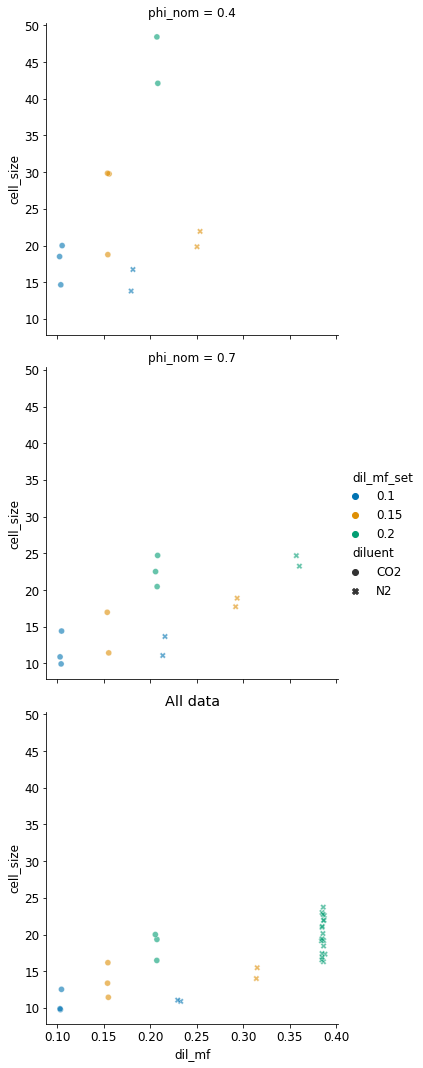

In [10]:
sns.relplot(
    x="dil_mf",
    y="cell_size",
    hue="dil_mf_set",
    style="diluent",
    row="phi_nom",
    data=df_shots,
    alpha=0.6,
    legend="full",
    palette=sns.palettes.color_palette("colorblind", n_colors=3),
)
plt.title("All data")
sns.despine()

In [11]:
df_mean = pd.DataFrame()
alpha = 0.975
estimator = np.median
for (dil_mf_set, diluent, phi_nom), sub_df in df_shots.groupby(["dil_mf_set", "diluent", "phi_nom"]):
    n_meas = len(sub_df)
    t_stat = t.ppf(0.975, n_meas - 1)
    denom = np.sqrt(n_meas)

    cell_size = estimator(unp.uarray(sub_df["cell_size"], sub_df["u_cell_size"]))
    cell_size_uncert_pop = sub_df["cell_size"].std() / denom * t_stat
    cell_size += un.ufloat(0, cell_size_uncert_pop)

    dil_mf = estimator(unp.uarray(sub_df["dil_mf"], sub_df["u_dil_mf"]))
    dil_mf_uncert_pop = sub_df["dil_mf"].std() / denom * t_stat
    dil_mf += un.ufloat(0, dil_mf_uncert_pop)
    this_row = pd.DataFrame(
        [
            [
                diluent,
                dil_mf_set,
                phi_nom,
                cell_size.nominal_value,
                cell_size.std_dev,
                dil_mf.nominal_value,
                dil_mf.std_dev,
            ]
        ],
        columns=[
            "diluent",
            "dil_mf_set",
            "phi_nom",
            "cell_size",
            "u_cell_size",
            "dil_mf",
            "u_dil_mf",
        ],
    )
    df_mean = pd.concat((this_row, df_mean))

df_mean.dropna(axis=0, inplace=True)
df_mean

,diluent,dil_mf_set,phi_nom,cell_size,u_cell_size,dil_mf,u_dil_mf
0,N2,0.20,1.0,19.413287,1.503893,0.385582,0.000504
0,N2,0.20,0.7,23.968649,9.168489,0.358624,0.020786
0,CO2,0.20,1.0,19.334457,4.708290,0.207064,0.002380
0,CO2,0.20,0.7,22.513562,5.323760,0.207389,0.002869
0,CO2,0.20,0.4,45.265852,40.192903,0.207642,0.006298
0,N2,0.15,1.0,14.738297,9.389725,0.314473,0.005640
0,N2,0.15,0.7,18.309480,7.414340,0.292569,0.010343
0,N2,0.15,0.4,20.878385,13.335739,0.251906,0.020976
0,CO2,0.15,1.0,13.372355,5.941254,0.154501,0.001072
0,CO2,0.15,0.7,14.199823,35.149942,0.154600,0.010021


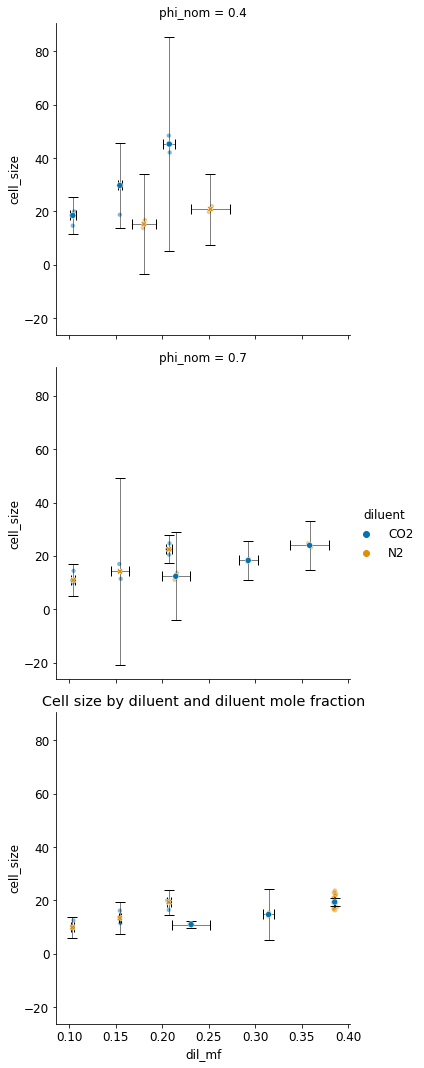

In [12]:
plots = sns.relplot(
    x="dil_mf",
    y="cell_size",
    row="phi_nom",
    hue="diluent",
    data=df_shots,
    zorder=-2,
    markers=["."],
    s=20,
    alpha=0.5,
)
# for diluent, df_diluent in df_mean.groupby("diluent"):
#     plt.errorbar(
#         df_diluent.dil_mf,
#         df_diluent.cell_size,
#         df_diluent.u_cell_size,
#         df_diluent.u_dil_mf,
#         barsabove=True,
#         ls="",
#         c="k",
#         elinewidth=1,
#         capsize=3,
#         zorder=-1,
#     )
for phi_nom, ax in plots.axes_dict.items():
    df_axes = df_mean[df_mean["phi_nom"] == phi_nom].copy()
    ax.errorbar(
        x=df_axes["dil_mf"],
        y=df_axes["cell_size"],
        xerr=df_axes["u_dil_mf"],
        yerr=df_axes["u_cell_size"],
        zorder=-1,
        elinewidth=0.5,
        capsize=5,
        fmt="none",
        c="k",
    )
    sns.scatterplot(
        x="dil_mf",
        y="cell_size",
        style="diluent",
        hue="diluent",
        data=df_axes,
        ax=ax,
        legend=False,
    )
plt.title("Cell size by diluent and diluent mole fraction")
sns.despine()

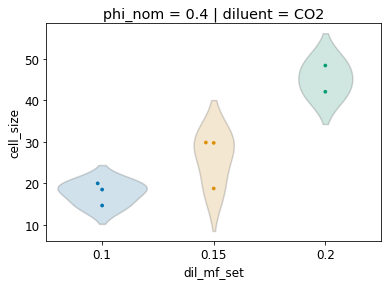

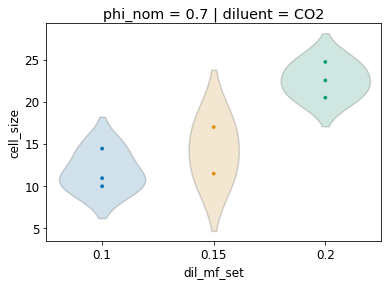

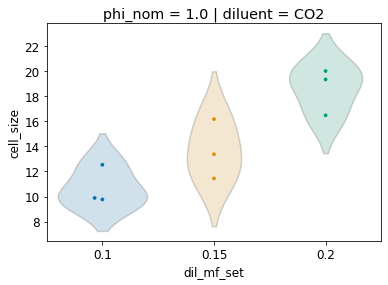

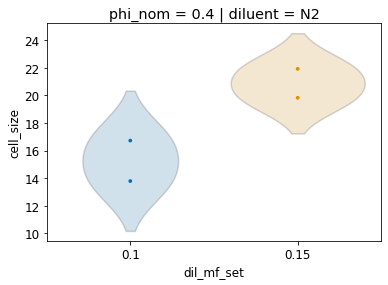

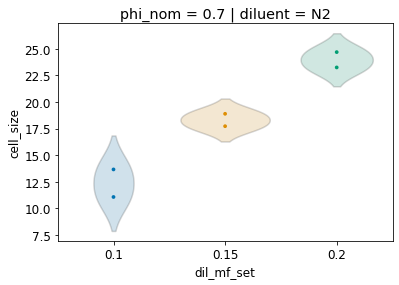

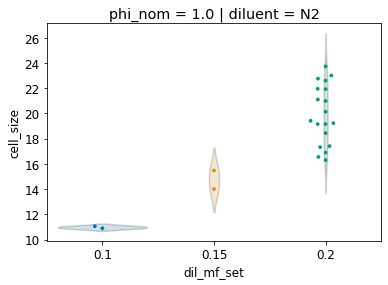

In [13]:
for (diluent, phi_nom), df_diluent in df_shots.groupby(["diluent", "phi_nom"]):
    plt.figure()
    _sub_df_mean = df_mean[
        (df_mean["diluent"] == diluent)
        & (df_mean["phi_nom"] == phi_nom)
    ]
    ax = sns.violinplot(x="dil_mf_set", y="cell_size", data=df_diluent, inner=None)
    plt.setp(ax.collections, alpha=0.2)
    sns.swarmplot(
        x="dil_mf_set",
        y="cell_size",
        data=df_diluent,
        marker=".",
        s=7.5,
        edgecolor="w",
        linewidth=0,
    )
    sns.scatterplot(
        x=len(_sub_df_mean),
        y="cell_size",
        marker="+",
        color="k",
        s=50,
        linewidth=2,
        data=_sub_df_mean,
        zorder=1000,
        edgecolor="w",
    )
    plt.title(f"phi_nom = {phi_nom} | diluent = {diluent}")

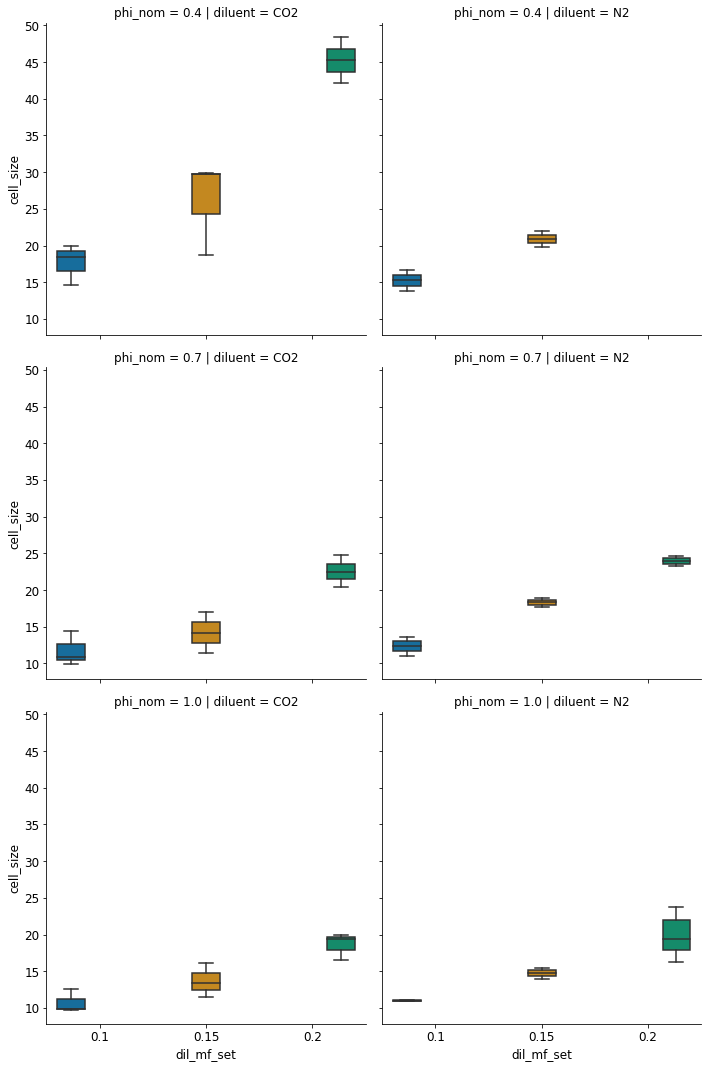

In [14]:
sns.catplot(
    x="dil_mf_set",
    y="cell_size",
    hue="dil_mf_set",
    col="diluent",
    row="phi_nom",
    data=df_shots,
    kind="box",
)

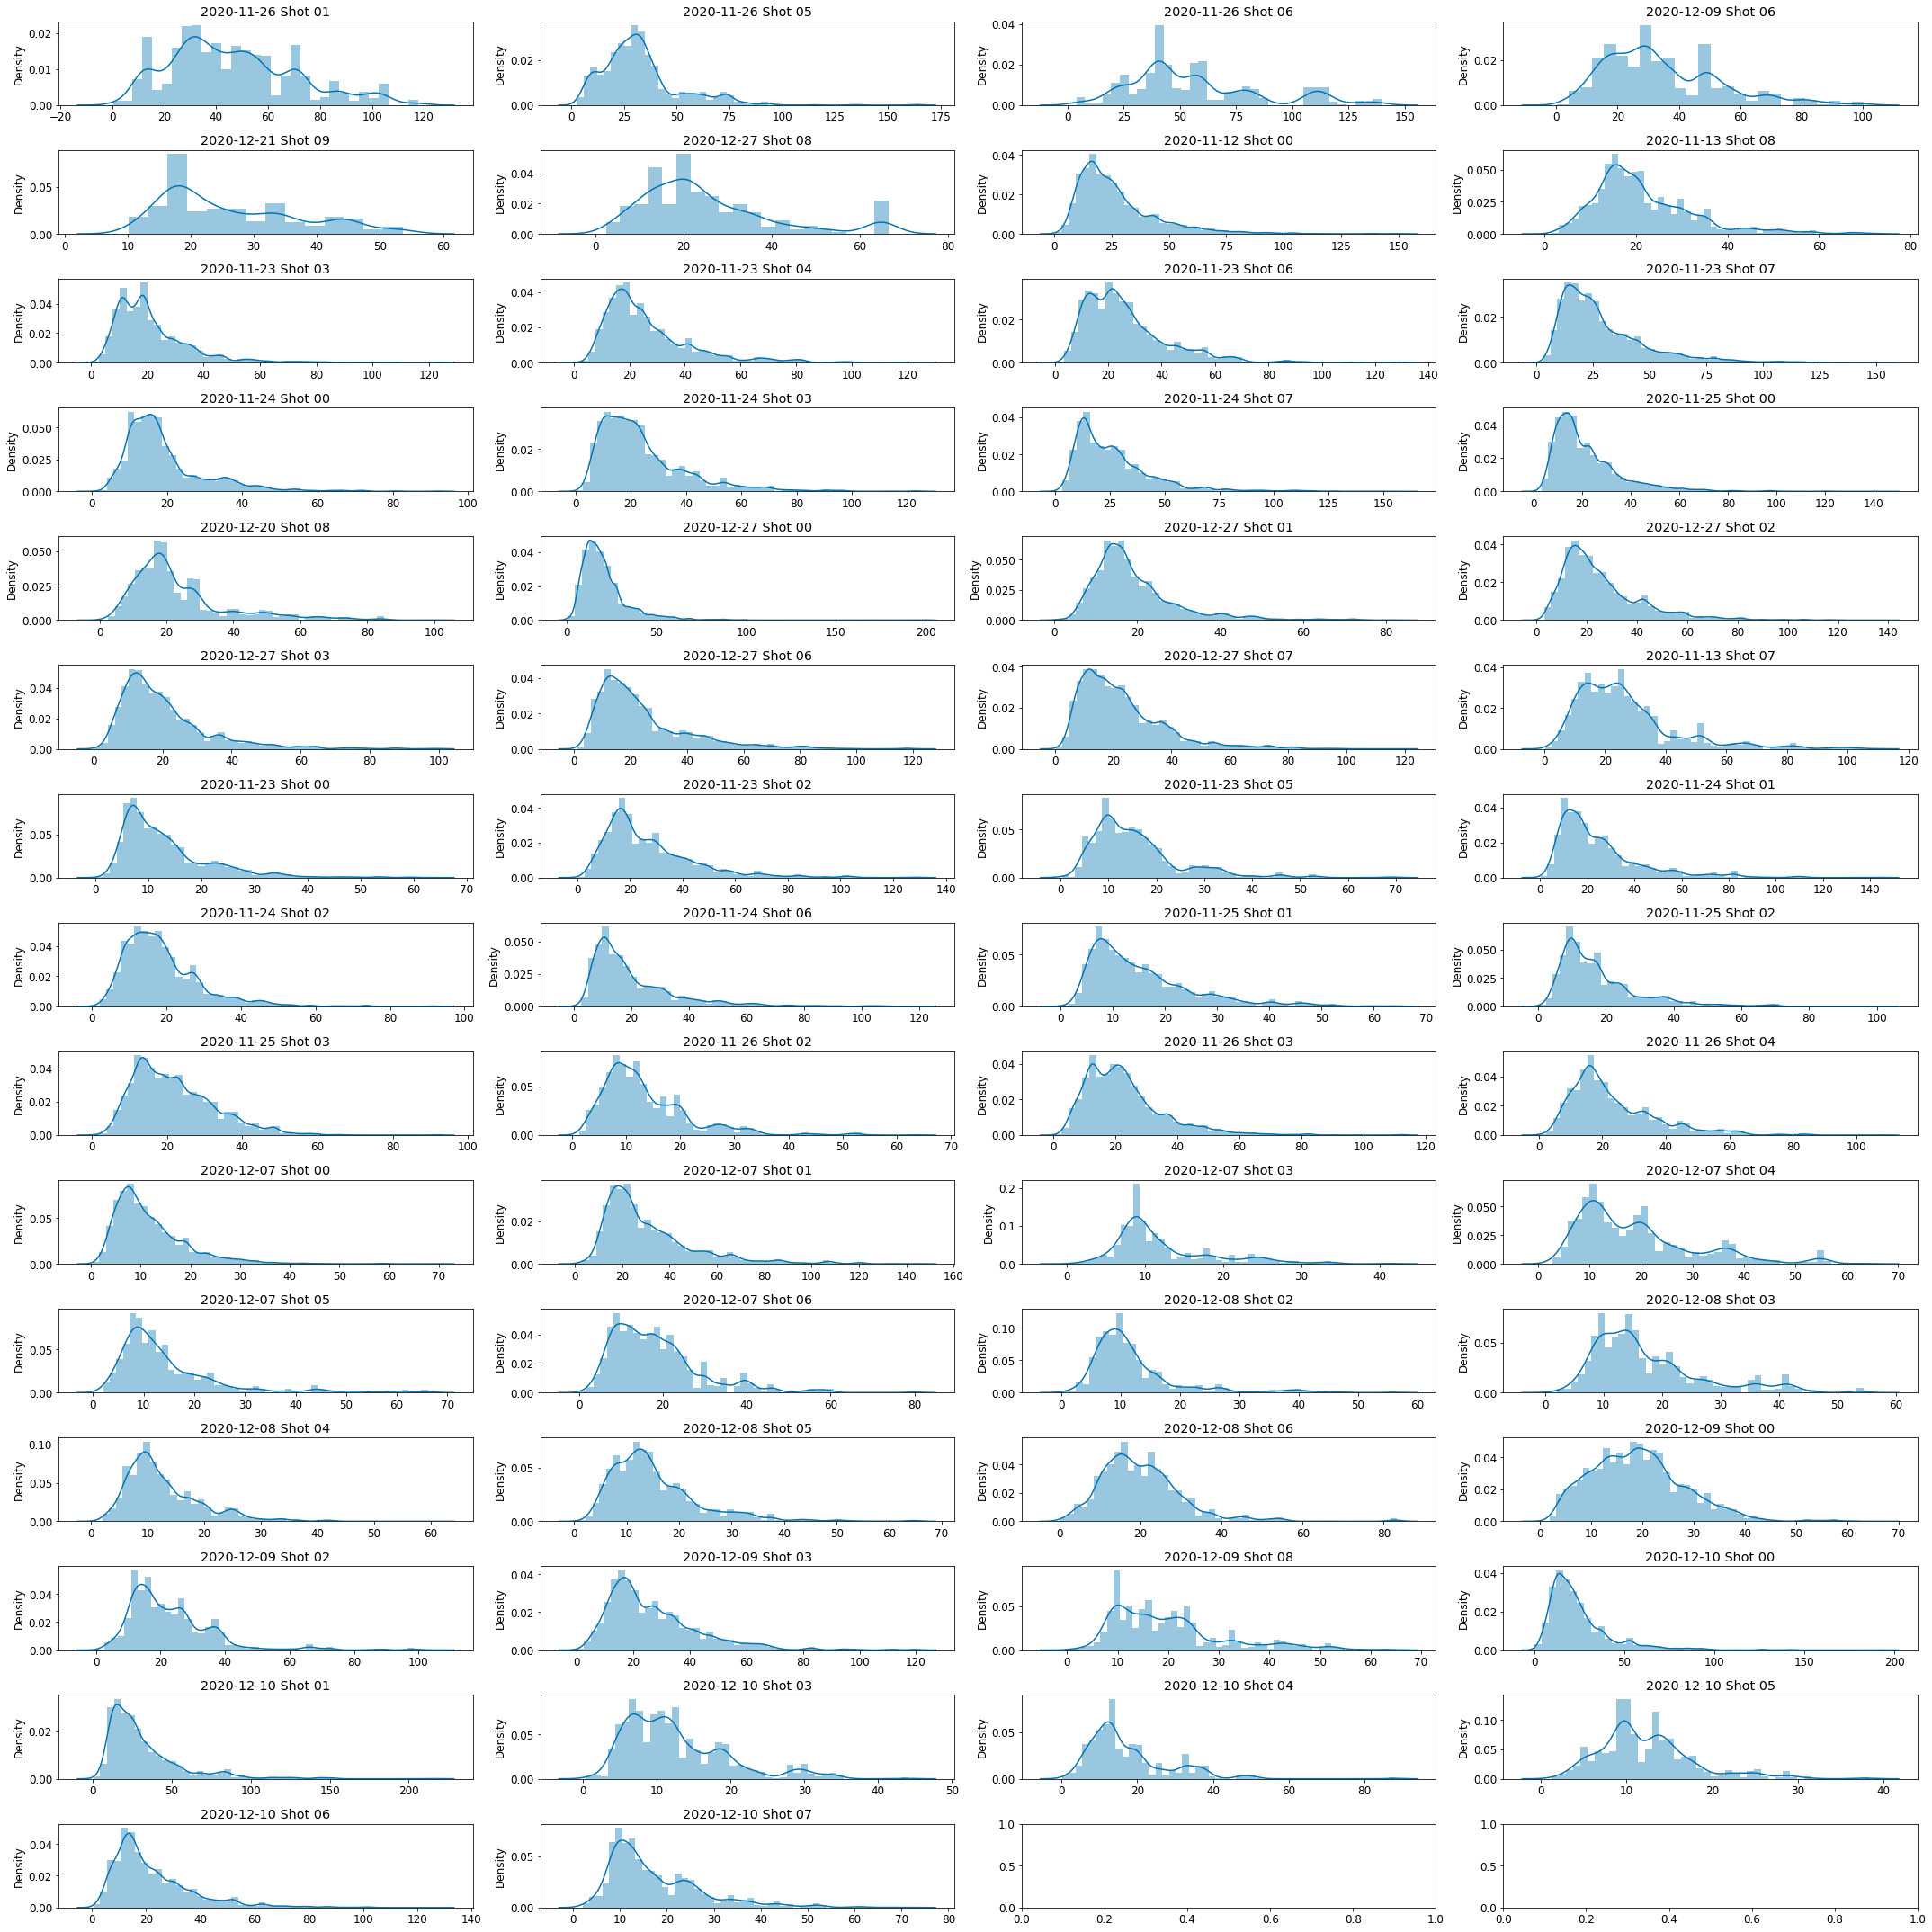

In [18]:
import warnings
with warnings.catch_warnings():
    # they deprecated distplot :(
    warnings.simplefilter("ignore")
    plt_rows = 4
    fig, ax = plt.subplots(
        int(np.ceil(len(results) / plt_rows)), plt_rows, figsize=(30, 30)
    )
    ax = ax.flatten()
    for idx, r in enumerate(results):
        sns.distplot(r.full_data.all.nominal, ax=ax[idx])
        ax[idx].set_title(r.shot)
plt.tight_layout()